In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi
from numpy import linalg as LA

import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import qiskit.tools.visualization as qkviz
from qiskit.tools.visualization import circuit_drawer
from qiskit.tools.monitor import job_monitor
from qiskit import BasicAer

from qiskit import execute, Aer, IBMQ


# Import from Qiskit Aer noise module
from qiskit.providers.aer.noise import NoiseModel
import qiskit.providers.aer.noise as noise

C:\ProgramData\Anaconda3\lib\site-packages\requests\__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
def Ang_theta(Delta0,k_vec):
    kx = k_vec[0]
    ky = k_vec[1]
    Delta = Delta0 + np.cos(kx) + np.cos(ky)
    T = np.sin(kx)
    D = np.sin(ky)
    E = np.sqrt(T**2 + D**2 + Delta**2)
    Inp = np.sqrt(T**2 + D**2) # Inp always larger than 0
    theta = np.arctan2(Inp,Delta)
    return theta

def Ang_varphi(Delta0,k_vec):
    kx = k_vec[0]
    ky = k_vec[1]
    T = np.sin(kx)
    D = np.sin(ky)
    Inp = np.sqrt(T**2 + D**2)
    if Inp<=1e-10:
        varphi = 0
    else:
        varphi = np.arctan2(D,T)
    return varphi

def build_U(vec1,vec2):
    in_product = np.dot(vec1,vec2.conj())

    U = in_product / np.abs(in_product)

    return U

In [3]:
def xlink(Delta0, kx, ky, Dkx):
    Nx = len(kx)
    Ny = len(ky)
    Ux = np.zeros((Nx*Ny),complex)
    for nx in range(Nx):
        for ny in range(Ny):
            k = np.array([kx[nx],ky[ny]], float)
            theta = Ang_theta(Delta0,k)
            varphi = Ang_varphi(Delta0,k)
            psi = np.array([-np.sin(theta/2)*np.exp(1j*varphi),np.cos(theta/2)])
            ############
            k = np.array([kx[nx]+Dkx,ky[ny]], float)
            theta = Ang_theta(Delta0,k)
            varphi = Ang_varphi(Delta0,k)
            psiDx = np.array([-np.sin(theta/2)*np.exp(1j*varphi),np.cos(theta/2)])
            Ux[nx*Ny+ny] = build_U(psi, psiDx )
    return Ux

def ylink(Delta0, kx, ky, Dky):
    Nx = len(kx)
    Ny = len(ky)
    Uy = np.zeros((Nx*Ny),complex)
    for nx in range(Nx):
        for ny in range(Ny):
            k = np.array([kx[nx],ky[ny]], float)
            theta = Ang_theta(Delta0,k)
            varphi = Ang_varphi(Delta0,k)
            psi = np.array([-np.sin(theta/2)*np.exp(1j*varphi),np.cos(theta/2)])
            ############
            k = np.array([kx[nx],ky[ny]+Dky], float)
            theta = Ang_theta(Delta0,k)
            varphi = Ang_varphi(Delta0,k)
            psiDy = np.array([-np.sin(theta/2)*np.exp(1j*varphi),np.cos(theta/2)])
            Uy[nx*Ny+ny] = build_U(psi, psiDy )
    return Uy

In [4]:
N = 8
kx = np.arange(0,N,1)*2*pi/N
ky = np.arange(0,N,1)*2*pi/N
Dkx = (2.*pi)/N
Dky = (2.*pi)/N

Ny = len(ky)

Dlist0=np.linspace(-2.1,-1.9,21)

chernN = np.zeros(len(Dlist0))
for nd, Delta in enumerate(Dlist0):
    Ux = xlink(Delta, kx, ky, Dkx)
    Uy = ylink(Delta, kx, ky, Dky)
    sumNc = 0
    for nx in range(len(kx)):
        for ny in range(len(ky)):
            U1x = Ux[nx*Ny+ny]
            U2y = Uy[nx*Ny+ny]
            if ny+1==Ny:
                U1y = Ux[nx*Ny]
            else:
                U1y = Ux[nx*Ny+(ny+1)]
            if nx+1==Ny:
                U2x = Uy[ny]
            else:
                U2x = Uy[(nx+1)*Ny+ny]
            LF = np.log( U1x * U2x * 1./U1y * 1./U2y)
            sumNc += LF
    chernN[nd] = sumNc.imag/(2.*pi)

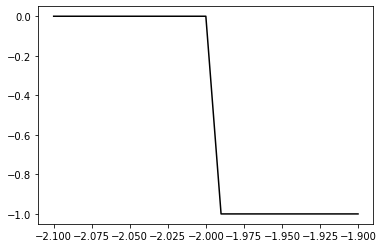

In [5]:
plt.plot(Dlist0,chernN,'k-',label=r'Exact')

In [6]:
def U(qc,qt,theta,phi,lam):
    qc.cx(qt[2],qt[1])
    qc.cu3(theta, phi, lam, qt[1], qt[2])
    qc.cx(qt[2],qt[1])
    
def CCU1(qc,qt,theta,phi,lam):
    qc.cu3(theta, -lam+pi, -phi+pi, qt[1], qt[2])
    qc.cx(qt[0],qt[1])
    qc.cu3(theta, phi, lam, qt[1], qt[2])
    qc.cx(qt[0],qt[1])
    qc.cu3(theta, -lam+pi, -phi+pi, qt[0], qt[2])
    
def CCU(qc,qt,theta,phi,lam):
    qc.cu3(theta, phi, lam, qt[1], qt[2])
    qc.cx(qt[0],qt[1])
    qc.cu3(theta, -lam+pi, -phi+pi, qt[1], qt[2])
    qc.cx(qt[0],qt[1])
    qc.cu3(theta, phi, lam, qt[0], qt[2])
    
def BC_real(qc, qt, c, theta1, phi1, lam1, theta2, lam2, phi2):
    qc.h(qt[0])
    qc.x(qt[2])
    U(qc,qt,theta1,phi1,lam1)
    qc.ccx(qt[0],qt[2],qt[1])
    CCU1(qc,qt,theta1/2,phi1,lam1)
    CCU(qc,qt,theta2/2,phi2,lam2)
    qc.ccx(qt[0],qt[2],qt[1])
    qc.u3(-pi/2,0,0,qt[0])
    qc.barrier(qt)
    qc.measure(qt[0], c[0])
    
def BC_imag(qc, qt, c, theta1, phi1, lam1, theta2, lam2, phi2):
    qc.h(qt[0])
    qc.x(qt[2])
    U(qc,qt,theta1,phi1,lam1)
    qc.ccx(qt[0],qt[2],qt[1])
    CCU1(qc,qt,theta1/2,phi1,lam1)
    CCU(qc,qt,theta2/2,phi2,lam2)
    qc.ccx(qt[0],qt[2],qt[1])
    qc.u3(pi/2,-pi/2,pi/2,qt[0])
    qc.barrier(qt)
    qc.measure(qt[0], c[0])
    
def buildR(theta,thetap,varphi,varphip):
    
    qt = QuantumRegister(3,'sys')
    c = ClassicalRegister(1)
    qc = QuantumCircuit(qt, c)
    
    theta1 = theta
    theta2 = thetap
    lam1 = -varphi
    phi1 = varphi
    lam2 = -varphip
    phi2 = varphip
    
    BC_real(qc, qt, c, theta1, phi1, lam1, theta2, lam2, phi2)

    return qc

def buildI(theta,thetap,varphi,varphip):
    
    qt = QuantumRegister(3,'sys')
    c = ClassicalRegister(1)
    qc = QuantumCircuit(qt, c)
    
    theta1 = theta
    theta2 = thetap
    lam1 = -varphi
    phi1 = varphi
    lam2 = -varphip
    phi2 = varphip
    
    BC_imag(qc, qt, c, theta1, phi1, lam1, theta2, lam2, phi2)

    return qc

def Ux_circuit(Delta0, kx, ky, Dkx):
    Nx = len(kx)
    Ny = len(ky)
    circuits = []
    for nx in range(Nx):
        for ny in range(Ny):
            k = np.array([kx[nx],ky[ny]], float)
            theta = Ang_theta(Delta0,k)
            varphi = Ang_varphi(Delta0,k)
            ### neighbored
            k = np.array([kx[nx]+Dkx,ky[ny]], float)
            thetapx = Ang_theta(Delta0,k)
            varphipx = Ang_varphi(Delta0,k)
            #### real circuit append
            qc = buildR(theta,thetapx,varphi,varphipx)
            circuits.append(qc)
            #### imaginary circuit append
            qc = buildI(theta,thetapx,varphi,varphipx)
            circuits.append(qc)
    return circuits

def Uy_circuit(Delta0, kx, ky, Dky):
    Nx = len(kx)
    Ny = len(ky)
    circuits = []
    for nx in range(Nx):
        for ny in range(Ny):
            k = np.array([kx[nx],ky[ny]], float)
            theta = Ang_theta(Delta0,k)
            varphi = Ang_varphi(Delta0,k)
            ### neighbored
            k = np.array([kx[nx],ky[ny]+Dky], float)
            thetapx = Ang_theta(Delta0,k)
            varphipx = Ang_varphi(Delta0,k)
            #### real circuit append
            qc = buildR(theta,thetapx,varphi,varphipx)
            circuits.append(qc)
            #### imaginary circuit append
            qc = buildI(theta,thetapx,varphi,varphipx)
            circuits.append(qc)
    return circuits

In [7]:
def obtain_result(joblist,nshots,Num):
    result = joblist.result()
    Uc = np.zeros((Num),complex)
    for nx in range(Num):
        Rets= np.zeros(2)
        for n in range(2):
            num = result.get_counts(n+2*nx)
            r=list(num.keys())
            a=list(num.values())
            Num_Sta = np.zeros(2)
            coe = np.zeros(2)
            for j in range(0,len(r)):
                label = [ int(s) for s in r[j] ]
                lab_state = 0
                for m in range(len(label)):
                    lab_state = lab_state + 2**m*label[m]
                Num_Sta[lab_state] = a[j]/nshots
                coe[lab_state] =(-1)**(np.sum(label))
            Rets[n] = np.dot(coe,Num_Sta)
        UR = Rets[0]
        UI = Rets[1]
        Uc[nx] = (UR + 1j*UI) / np.abs(UR + 1j*UI)
    return Uc

In [8]:
def get_Chern(kx,ky,Ux,Uy):
    sumNc = 0
    for nx in range(len(kx)):
        for ny in range(len(ky)):
            U1x = Ux[nx*Ny+ny]
            U2y = Uy[nx*Ny+ny]
            if ny+1==Ny:
                U1y = Ux[nx*Ny]
            else:
                U1y = Ux[nx*Ny+(ny+1)]
            if nx+1==Ny:
                U2x = Uy[ny]
            else:
                U2x = Uy[(nx+1)*Ny+ny]
            LF = np.log( U1x * U2x * 1./U1y * 1./U2y)
            sumNc += LF
    ChernNum = sumNc.imag/(2.*pi)
    return ChernNum

In [9]:
backend_sim = BasicAer.get_backend('qasm_simulator')
nshots=1024*5

# Error probabilities 010
prob_1 = 0.006  # 1-qubit gate
prob_2 = 10*prob_1   # 2-qubit gate

# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)

# Add errors to noise model
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

In [21]:
Dlist=np.linspace(-2.0101,-1.9901,21)
print(Dlist)

[-2.0101 -2.0091 -2.0081 -2.0071 -2.0061 -2.0051 -2.0041 -2.0031 -2.0021
 -2.0011 -2.0001 -1.9991 -1.9981 -1.9971 -1.9961 -1.9951 -1.9941 -1.9931
 -1.9921 -1.9911 -1.9901]


In [19]:
Dlist=np.linspace(-2.0101,-1.9901,21)
ChernNum006 = np.zeros((len(Dlist),50),dtype=float)
for n_repeat in range(50):
    for nd, Delta in enumerate(Dlist):
        gap = Delta
        ## x-links
        circx = Ux_circuit(Delta, kx, ky, Dkx)
        qobj=qiskit.transpile(circx,initial_layout=[0,1,2])
        job = execute(qobj, Aer.get_backend('qasm_simulator'), 
                      basis_gates=basis_gates,shots=nshots, 
                      noise_model=noise_model)
        Ux = obtain_result(job,nshots,N**2)
        ## y-links
        circy = Uy_circuit(Delta, kx, ky, Dky)
        qobj=qiskit.transpile(circy,initial_layout=[0,1,2])
        job = execute(qobj, Aer.get_backend('qasm_simulator'), 
                      basis_gates=basis_gates,shots=nshots, 
                      noise_model=noise_model)
        Uy = obtain_result(job,nshots,N**2)
        ChernNum006[nd,n_repeat] = get_Chern(kx,ky,Ux,Uy)
    print(n_repeat)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


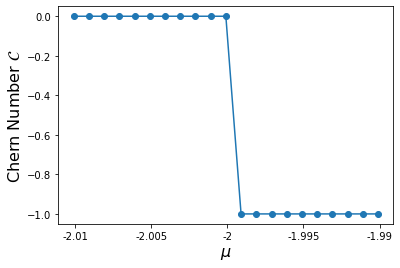

In [23]:
fig, axs = plt.subplots(1, 1)
axs.plot(Dlist,np.mean(ChernNum006,axis=1),'-o')
axs.set_ylabel(r'Chern Number $\mathcal{C}$',fontsize=16)
axs.set_xlabel(r'$\mu$',fontsize=16)
axs.set_xticks([-2.01,-2.005,-2,-1.995,-1.99])
axs.set_xticklabels(['-2.01','-2.005','-2','-1.995','-1.99'])
plt.savefig('close_critical_0.pdf', bbox_inches='tight')

In [20]:
np.save("ChernNum006_am2.npy",ChernNum006)
np.save("Dlist_am2.npy",Dlist)

In [10]:
Dlist1=np.linspace(2-2.0101,2-1.9901,21)
ChernNum006_1 = np.zeros((len(Dlist1),50),dtype=float)
for n_repeat in range(50):
    for nd, Delta in enumerate(Dlist1):
        gap = Delta
        ## x-links
        circx = Ux_circuit(Delta, kx, ky, Dkx)
        qobj=qiskit.transpile(circx,initial_layout=[0,1,2])
        job = execute(qobj, Aer.get_backend('qasm_simulator'), 
                      basis_gates=basis_gates,shots=nshots, 
                      noise_model=noise_model)
        Ux = obtain_result(job,nshots,N**2)
        ## y-links
        circy = Uy_circuit(Delta, kx, ky, Dky)
        qobj=qiskit.transpile(circy,initial_layout=[0,1,2])
        job = execute(qobj, Aer.get_backend('qasm_simulator'), 
                      basis_gates=basis_gates,shots=nshots, 
                      noise_model=noise_model)
        Uy = obtain_result(job,nshots,N**2)
        ChernNum006_1[nd,n_repeat] = get_Chern(kx,ky,Ux,Uy)
    print(n_repeat)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [13]:
Dlist2=np.linspace(4-2.0101,4-1.9901,21)
print(Dlist2)

[1.9899 1.9909 1.9919 1.9929 1.9939 1.9949 1.9959 1.9969 1.9979 1.9989
 1.9999 2.0009 2.0019 2.0029 2.0039 2.0049 2.0059 2.0069 2.0079 2.0089
 2.0099]


In [15]:
Dlist2=np.linspace(4-2.0101,4-1.9901,21)
ChernNum006_2 = np.zeros((len(Dlist2),50),dtype=float)
for n_repeat in range(50):
    for nd, Delta in enumerate(Dlist2):
        gap = Delta
        ## x-links
        circx = Ux_circuit(Delta, kx, ky, Dkx)
        qobj=qiskit.transpile(circx,initial_layout=[0,1,2])
        job = execute(qobj, Aer.get_backend('qasm_simulator'), 
                      basis_gates=basis_gates,shots=nshots, 
                      noise_model=noise_model)
        Ux = obtain_result(job,nshots,N**2)
        ## y-links
        circy = Uy_circuit(Delta, kx, ky, Dky)
        qobj=qiskit.transpile(circy,initial_layout=[0,1,2])
        job = execute(qobj, Aer.get_backend('qasm_simulator'), 
                      basis_gates=basis_gates,shots=nshots, 
                      noise_model=noise_model)
        Uy = obtain_result(job,nshots,N**2)
        ChernNum006_2[nd,n_repeat] = get_Chern(kx,ky,Ux,Uy)
    print(n_repeat)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


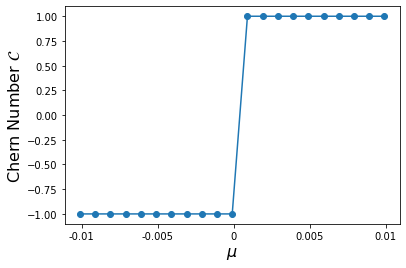

In [25]:
fig, axs = plt.subplots(1, 1)
axs.plot(Dlist1,np.mean(ChernNum006_1,axis=1),'-o')
axs.set_ylabel(r'Chern Number $\mathcal{C}$',fontsize=16)
axs.set_xlabel(r'$\mu$',fontsize=16)
axs.set_xticks([-0.01,-0.005,0,0.005,0.01])
axs.set_xticklabels(['-0.01','-0.005','0','0.005','0.01'])
plt.savefig('close_critical_1.pdf', bbox_inches='tight')

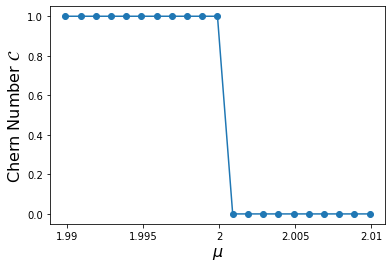

In [26]:
fig, axs = plt.subplots(1, 1)
axs.plot(Dlist2,np.mean(ChernNum006_2,axis=1),'-o')
axs.set_ylabel(r'Chern Number $\mathcal{C}$',fontsize=16)
axs.set_xlabel(r'$\mu$',fontsize=16)
axs.set_xticks([1.99,1.995,2,2.005,2.01])
axs.set_xticklabels(['1.99','1.995','2','2.005','2.01'])
plt.savefig('close_critical_2.pdf', bbox_inches='tight')

In [21]:
backend_sim = BasicAer.get_backend('qasm_simulator')
nshots=1024*5

# Error probabilities 010
prob_1 = 0.007  # 1-qubit gate
prob_2 = 10*prob_1   # 2-qubit gate

# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)

# Add errors to noise model
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

In [22]:
Dlist=np.linspace(-2.1,-1.9,21)
ChernNum005 = np.zeros((len(Dlist),50),dtype=float)
for n_repeat in range(50):
    for nd, Delta in enumerate(Dlist):
        gap = Delta
        ## x-links
        circx = Ux_circuit(Delta, kx, ky, Dkx)
        qobj=qiskit.transpile(circx,initial_layout=[0,1,2])
        job = execute(qobj, Aer.get_backend('qasm_simulator'), 
                      basis_gates=basis_gates,shots=nshots, 
                      noise_model=noise_model)
        Ux = obtain_result(job,nshots,N**2)
        ## y-links
        circy = Uy_circuit(Delta, kx, ky, Dky)
        qobj=qiskit.transpile(circy,initial_layout=[0,1,2])
        job = execute(qobj, Aer.get_backend('qasm_simulator'), 
                      basis_gates=basis_gates,shots=nshots, 
                      noise_model=noise_model)
        Uy = obtain_result(job,nshots,N**2)
        ChernNum005[nd,n_repeat] = get_Chern(kx,ky,Ux,Uy)
    print(n_repeat)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [23]:
Dlist1=np.linspace(-0.1,0.1,21)
ChernNum005_1 = np.zeros((len(Dlist),50),dtype=float)
for n_repeat in range(50):
    for nd, Delta in enumerate(Dlist):
        gap = Delta
        ## x-links
        circx = Ux_circuit(Delta, kx, ky, Dkx)
        qobj=qiskit.transpile(circx,initial_layout=[0,1,2])
        job = execute(qobj, Aer.get_backend('qasm_simulator'), 
                      basis_gates=basis_gates,shots=nshots, 
                      noise_model=noise_model)
        Ux = obtain_result(job,nshots,N**2)
        ## y-links
        circy = Uy_circuit(Delta, kx, ky, Dky)
        qobj=qiskit.transpile(circy,initial_layout=[0,1,2])
        job = execute(qobj, Aer.get_backend('qasm_simulator'), 
                      basis_gates=basis_gates,shots=nshots, 
                      noise_model=noise_model)
        Uy = obtain_result(job,nshots,N**2)
        ChernNum005_1[nd,n_repeat] = get_Chern(kx,ky,Ux,Uy)
    print(n_repeat)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [24]:
Dlist2=np.linspace(1.9,2.1,21)
ChernNum005_2 = np.zeros((len(Dlist),50),dtype=float)
for n_repeat in range(50):
    for nd, Delta in enumerate(Dlist):
        gap = Delta
        ## x-links
        circx = Ux_circuit(Delta, kx, ky, Dkx)
        qobj=qiskit.transpile(circx,initial_layout=[0,1,2])
        job = execute(qobj, Aer.get_backend('qasm_simulator'), 
                      basis_gates=basis_gates,shots=nshots, 
                      noise_model=noise_model)
        Ux = obtain_result(job,nshots,N**2)
        ## y-links
        circy = Uy_circuit(Delta, kx, ky, Dky)
        qobj=qiskit.transpile(circy,initial_layout=[0,1,2])
        job = execute(qobj, Aer.get_backend('qasm_simulator'), 
                      basis_gates=basis_gates,shots=nshots, 
                      noise_model=noise_model)
        Uy = obtain_result(job,nshots,N**2)
        ChernNum005_2[nd,n_repeat] = get_Chern(kx,ky,Ux,Uy)
    print(n_repeat)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


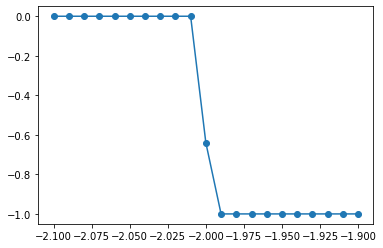

In [25]:
plt.plot(Dlist,np.mean(ChernNum005,axis=1),'-o')

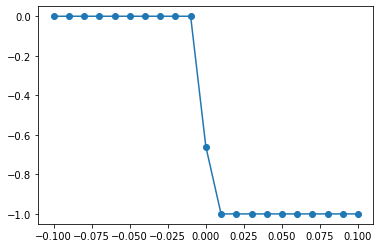

In [26]:
plt.plot(Dlist1,np.mean(ChernNum005_1,axis=1),'-o')

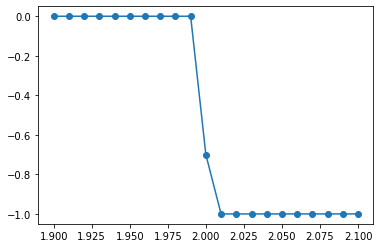

In [27]:
plt.plot(Dlist2,np.mean(ChernNum005_2,axis=1),'-o')

In [28]:
np.save("006_R1_001.npy",ChernNum006)
np.save("006_R2_001.npy",ChernNum006_1)
np.save("006_R3_001.npy",ChernNum006_2)

In [29]:
np.save("point_R1_001.npy",Dlist)
np.save("point_R2_001.npy",Dlist1)
np.save("point_R3_001.npy",Dlist2)

In [30]:
np.save("005_R1_001.npy",ChernNum005)
np.save("005_R2_001.npy",ChernNum005_1)
np.save("005_R3_001.npy",ChernNum005_2)

In [31]:
np.shape(ChernNum006)

(21, 50)

In [36]:
a=np.load("005_R1_001.npy")

In [37]:
a.shape

(21, 50)